=== PERFIL DE LOS 3 GRUPOS DE CLIENTES ===
   Cluster  Recencia  Frecuencia   Monto  Unidades_Totales
0        0     22.02        8.07  242.96             27.02
1        1     27.69       12.33  414.31             44.71
2        2     87.17        6.50  188.71             22.22

=== CANTIDAD DE CLIENTES POR GRUPO ===
Cluster
0    160
1    108
2     58
Name: count, dtype: int64


C:\Users\mario\AppData\Local\Temp\ipykernel_5688\503382106.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Recencia", data=clientes_rfm, ax=axes[0], palette="viridis")
C:\Users\mario\AppData\Local\Temp\ipykernel_5688\503382106.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Frecuencia", data=clientes_rfm, ax=axes[1], palette="viridis")
C:\Users\mario\AppData\Local\Temp\ipykernel_5688\503382106.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Monto", data=clientes_rfm, ax=axes[2], 

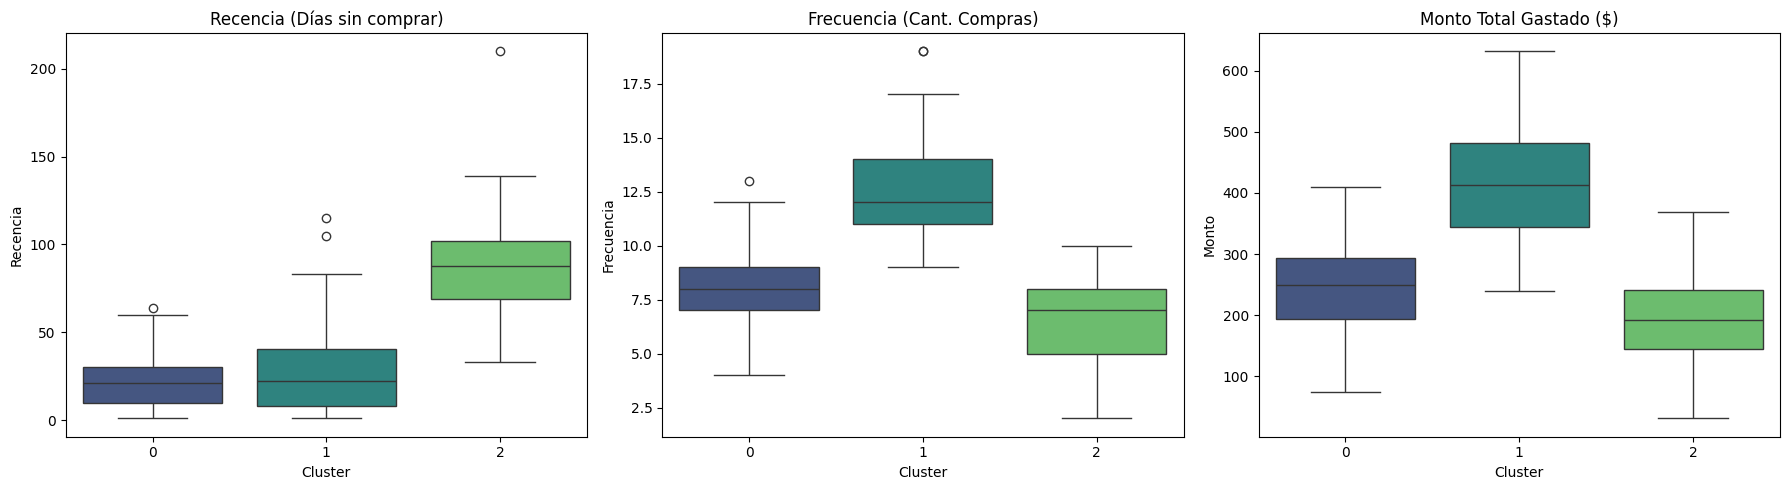

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1. Cargar el Master Dataset
# Ajusta la ruta si es necesario, asumo la misma estructura que en tus PDFs
current_dir = Path.cwd()
# Busca el archivo subiendo niveles si no está en la carpeta actual
master_path = current_dir / "data_cleaned" / "master.parquet"
if not master_path.exists():
    # Intento alternativo común según tus documentos
    master_path = current_dir.parent / "data_cleaned" / "master.parquet"

df = pd.read_parquet(master_path)

# 2. Preparar datos por Cliente (Feature Engineering: RFM)
# Definimos la fecha de referencia (día siguiente a la última venta registrada)
fecha_referencia = df['Fecha'].max() + pd.Timedelta(days=1)

# Agrupamos por cliente calculando métricas clave
clientes_rfm = df.groupby("ID_Cliente").agg({
    "Fecha": lambda x: (fecha_referencia - x.max()).days,  # Recencia (días desde última compra)
    "ID_Venta": "nunique",                                 # Frecuencia (número de compras únicas)
    "ingreso": "sum",                                      # Monto (dinero total gastado)
    "Cantidad": "sum"                                      # Cantidad total de productos
}).reset_index()

# Renombramos columnas para claridad
clientes_rfm.columns = ["ID_Cliente", "Recencia", "Frecuencia", "Monto", "Unidades_Totales"]

# 3. Estandarizar los datos
# Es crucial porque el 'Monto' (miles) es mucho mayor que 'Frecuencia' (unidades)
scaler = StandardScaler()
features_to_scale = ["Recencia", "Frecuencia", "Monto", "Unidades_Totales"]
X_scaled = scaler.fit_transform(clientes_rfm[features_to_scale])

# 4. Aplicar K-Means con 3 Grupos (como solicitaste)
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
clientes_rfm["Cluster"] = kmeans.fit_predict(X_scaled)

# 5. Interpretar los Resultados
# Calculamos el promedio de cada métrica por grupo para entender qué significa cada uno
perfil_clusters = clientes_rfm.groupby("Cluster")[features_to_scale].mean().reset_index()

print("=== PERFIL DE LOS 3 GRUPOS DE CLIENTES ===")
print(perfil_clusters.round(2))
print("\n=== CANTIDAD DE CLIENTES POR GRUPO ===")
print(clientes_rfm["Cluster"].value_counts().sort_index())

# 6. Visualización Rápida (Boxplots para ver diferencias)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x="Cluster", y="Recencia", data=clientes_rfm, ax=axes[0], palette="viridis")
axes[0].set_title("Recencia (Días sin comprar)")

sns.boxplot(x="Cluster", y="Frecuencia", data=clientes_rfm, ax=axes[1], palette="viridis")
axes[1].set_title("Frecuencia (Cant. Compras)")

sns.boxplot(x="Cluster", y="Monto", data=clientes_rfm, ax=axes[2], palette="viridis")
axes[2].set_title("Monto Total Gastado ($)")

plt.tight_layout()
plt.show()